---
# **KAGGLE Project : "Chest X-Ray Images (Pneumonia)"**
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

Objectif : *detect pneumonia in chest X-ray images using a deep learning approach*

Authors :
- AUCOUTURIER Camille
- BALOCHE Valentin

---

# Importing necessary packages

In [2]:
import os
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import preprocessing
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3

# Loading and preparing data

In [3]:
# Definition of path files
path = "/data"
path_train = os.path.join(path, "train")
path_test = os.path.join(path, "test")

path_train_normal = glob.glob(path_train + "/NORMAL/*.jpeg")
path_train_bacterial_pneumonia = glob.glob(path_train + "/PNEUMONIA/BACTERIA*.jpeg")
path_train_viral_pneumonia = glob.glob(path_train + "/PNEUMONIA/VIRUS*.jpeg")

path_test_normal = glob.glob(path_test + "/NORMAL/*.jpeg")
path_test_bacterial_pneumonia = glob.glob(path_test + "/PNEUMONIA/BACTERIA*.jpeg")
path_test_viral_pneumonia = glob.glob(path_test + "/PNEUMONIA/VIRUS*.jpeg")

In [4]:
# Number of files in each folder
print(f"Training normal images : {len(path_train_normal)}")
print(f"Training bacterial pneumonia images : {len(path_train_bacterial_pneumonia)}")
print(f"Training viral pneumonia images : {len(path_train_viral_pneumonia)}")
print("\n")
print(f"Testing normal images : {len(path_test_normal)}")
print(f"Testing bacterial pneumonia images : {len(path_test_bacterial_pneumonia)}")
print(f"Testing viral pneumonia images : {len(path_test_viral_pneumonia)}")

Training normal images : 1349
Training bacterial pneumonia images : 2538
Training viral pneumonia images : 1345


Testing normal images : 234
Testing bacterial pneumonia images : 242
Testing viral pneumonia images : 148


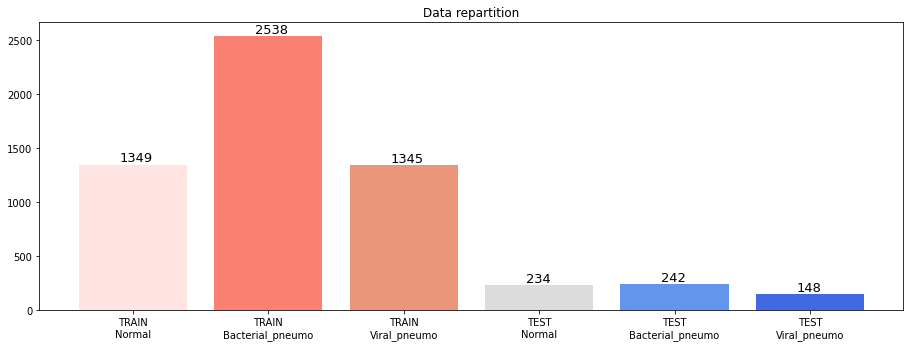

In [5]:
# Graphic representation of dataset
fig = plt.figure()
ax = fig.add_axes([0,0,2,1])
sets = ['TRAIN\nNormal', 'TRAIN\nBacterial_pneumo', 'TRAIN\nViral_pneumo', 'TEST\nNormal', 'TEST\nBacterial_pneumo', 'TEST\nViral_pneumo']
num = [len(path_train_normal), len(path_train_bacterial_pneumonia), len(path_train_viral_pneumonia), len(path_test_normal), len(path_test_bacterial_pneumonia), len(path_test_viral_pneumonia)]
ax.bar(sets, num, color=['mistyrose', 'salmon', 'darksalmon', 'gainsboro', 'cornflowerblue', 'royalblue'])
plt.title("Data repartition")

for p in ax.patches:
    ax.annotate((p.get_height()), (p.get_x()+0.3, p.get_height()+30), fontsize = 13)

plt.show()
plt.rcParams.update({'font.size': 12})

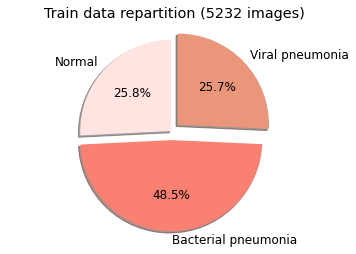

In [6]:
# Data train repartition pie chart
total_length = len(path_train_normal) + len(path_train_bacterial_pneumonia) + len(path_train_viral_pneumonia)
labels = 'Normal', 'Bacterial pneumonia', 'Viral pneumonia'
sizes = [len(path_train_normal)/total_length, len(path_train_bacterial_pneumonia)/total_length, len(path_train_viral_pneumonia)/total_length]
explode = (0, 0.1, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=['mistyrose', 'salmon', 'darksalmon'])
ax1.axis('equal')
plt.title("Train data repartition (5232 images)", loc = 'center')

plt.show()



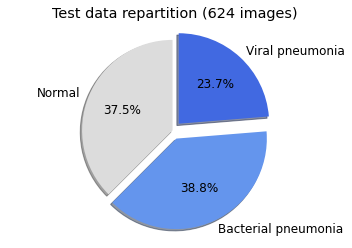

In [7]:
# Data test repartition pie chart
total_length = len(path_test_normal) + len(path_test_bacterial_pneumonia) + len(path_test_viral_pneumonia)
labels = 'Normal', 'Bacterial pneumonia', 'Viral pneumonia'
sizes = [len(path_test_normal)/total_length, len(path_test_bacterial_pneumonia)/total_length, len(path_test_viral_pneumonia)/total_length]
explode = (0, 0.1, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=['gainsboro', 'cornflowerblue', 'royalblue'])
ax1.axis('equal')
plt.title("Test data repartition (624 images)", loc = 'center')

plt.show()

In [8]:
# Creation of validation set (20% from each class from train data)
random.seed(1234)

data_val_normal = set(random.sample(path_train_normal, round(0.2 * len(path_train_normal))))
data_val_bacterial_pneumonia = set(random.sample(path_train_bacterial_pneumonia, round(0.2 * len(path_train_bacterial_pneumonia))))
data_val_viral_pneumonia = set(random.sample(path_train_viral_pneumonia, round(0.2 * len(path_train_viral_pneumonia))))

# Updating train data
data_train_normal = set(path_train_normal) - data_val_normal
data_train_bacterial_pneumonia = set(path_train_bacterial_pneumonia) - data_val_bacterial_pneumonia
data_train_viral_pneumonia = set(path_train_viral_pneumonia) - data_val_viral_pneumonia

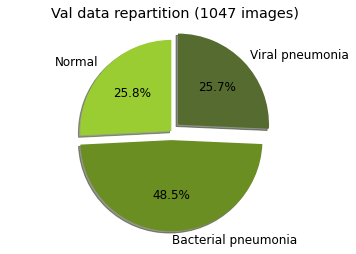

In [9]:
# Data val repartition pie chart
total_length = len(data_val_normal) + len(data_val_bacterial_pneumonia) + len(data_val_viral_pneumonia)
labels = 'Normal', 'Bacterial pneumonia', 'Viral pneumonia'
sizes = [len(data_val_normal)/total_length, len(data_val_bacterial_pneumonia)/total_length, len(data_val_viral_pneumonia)/total_length]
explode = (0, 0.1, 0.1)

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, colors=['yellowgreen', 'olivedrab', 'darkolivegreen'])
ax1.axis('equal')
plt.title("Val data repartition (1047 images)", loc = 'center')

plt.show()

In [10]:
# Image shapes before resizing are heterogeneous
for i in range (10):
    print(np.shape(load_img(path_train_normal[i])))

(1341, 1840, 3)
(1237, 1156, 3)
(1746, 2014, 3)
(1982, 2068, 3)
(1612, 1774, 3)
(1522, 1728, 3)
(1272, 1622, 3)
(1260, 1632, 3)
(1156, 1678, 3)
(1677, 1936, 3)


In [11]:
# Randomly selected images in order to see their shape
random.seed(11)
random_list = random.sample(path_train_normal, 3) + random.sample(path_train_bacterial_pneumonia, 3) + random.sample(path_train_viral_pneumonia, 3)
loaded_random_list = [load_img(img) for img in random_list]
np_loaded = [img_to_array(img) for img in loaded_random_list]
np_loaded = np.asarray(np_loaded)
np_loaded = np_loaded / 255

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


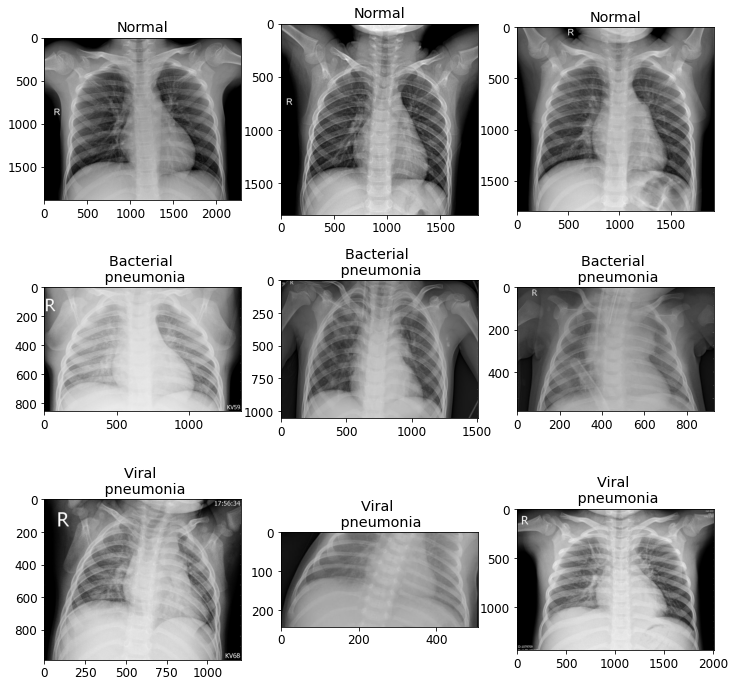

In [12]:
# Viewing of some randomly selected images in the train folder before resizing
plt.figure(figsize=(12,12))
j = -1
for i in range(0, len(np_loaded)):
    j += 1
    ax=plt.subplot(3, 3, j+1)
    plt.imshow((np_loaded[i]), cmap=plt.get_cmap("gray"))
    if j < 3 :
        plt.title("Normal")
    elif j < 6 :
        plt.title("Bacterial \n pneumonia")
    else :
        plt.title("Viral \n pneumonia")
plt.show() 

In [13]:
# Resizing in (224 x 224 x 3)
resized_random_list = [load_img(img, target_size=(224,224)) for img in random_list]
np_resized = (np.asarray([img_to_array(img) for img in resized_random_list])) / 255

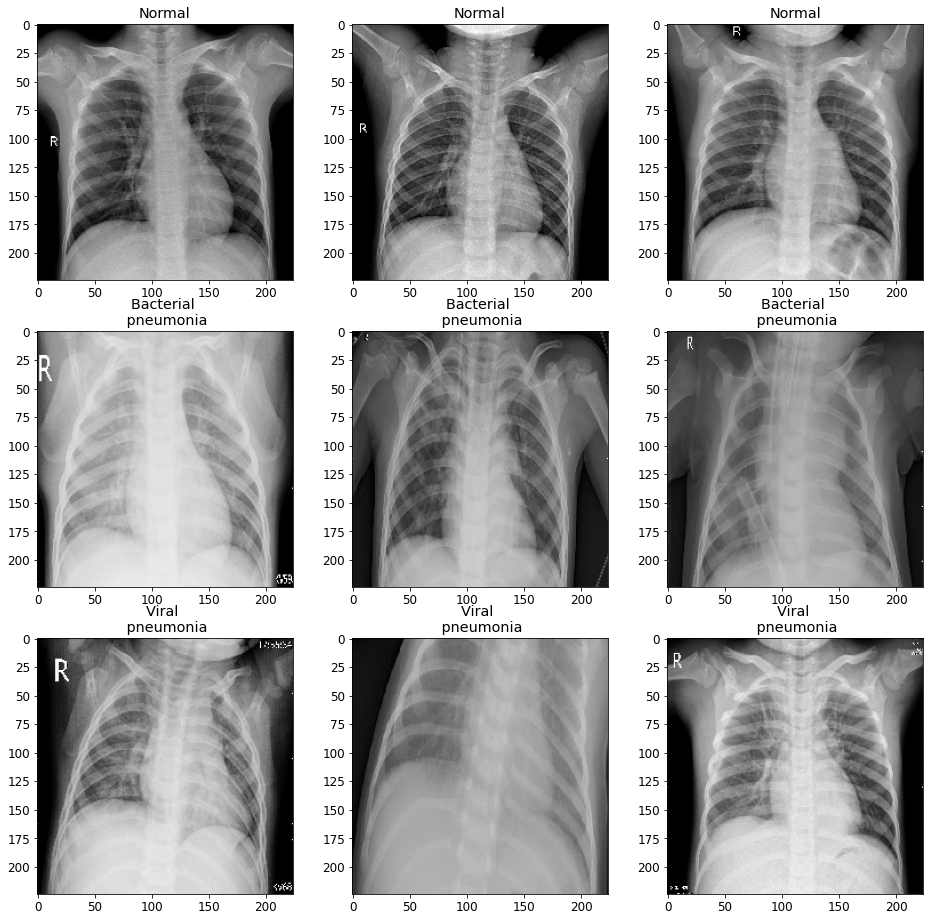

In [14]:
# Viewing of some randomly selected images in the train folder after resizing
plt.figure(figsize=(16,16))
j = -1
for i in range(0, len(np_resized)):
    j += 1
    ax=plt.subplot(3, 3, j+1)
    plt.imshow((np_resized[i]), cmap=plt.get_cmap("gray"))
    if j < 3 :
        plt.title("Normal")
    elif j < 6 :
        plt.title("Bacterial \n pneumonia")
    else :
        plt.title("Viral \n pneumonia")
plt.show() 

In [15]:
# Loading images in list from each folder and resizing in (224, 224, 3) RGB format
img_data_train_normal = [load_img(file, target_size=(224, 224)) for file in data_train_normal]
img_data_train_bacterial_pneumonia = [load_img(file, target_size=(224,224)) for file in data_train_bacterial_pneumonia]
img_data_train_viral_pneumonia = [load_img(file, target_size=(224,224)) for file in data_train_viral_pneumonia]

img_data_val_normal = [load_img(file, target_size=(224,224)) for file in data_val_normal]
img_data_val_bacterial_pneumonia =[load_img(file, target_size=(224,224)) for file in data_val_bacterial_pneumonia]
img_data_val_viral_pneumonia = [load_img(file, target_size=(224,224)) for file in data_val_viral_pneumonia]

img_data_test_normal = [load_img(file, target_size=(224,224)) for file in path_test_normal]
img_data_test_bacterial_pneumonia = [load_img(file, target_size=(224,224)) for file in path_test_bacterial_pneumonia]
img_data_test_viral_pneumonia = [load_img(file, target_size=(224,224)) for file in path_test_viral_pneumonia]

# **Part 1 : CNN with 2 classes --> Normal or Pneumonia**



In [16]:
# Conversing images in pixel matrix in aray
x_2train = [img_to_array(image) for image in img_data_train_normal]
x_2train.extend([img_to_array(image) for image in img_data_train_bacterial_pneumonia])
x_2train.extend([img_to_array(image) for image in img_data_train_viral_pneumonia])
x_2train = np.asarray(x_2train)

x_2val = [img_to_array(image) for image in img_data_val_normal]
x_2val.extend([img_to_array(image) for image in img_data_val_bacterial_pneumonia])
x_2val.extend([img_to_array(image) for image in img_data_val_viral_pneumonia])
x_2val = np.asarray(x_2val)

x_2test = [img_to_array(image) for image in img_data_test_normal]
x_2test.extend([img_to_array(image) for image in img_data_test_bacterial_pneumonia])
x_2test.extend([img_to_array(image) for image in img_data_test_viral_pneumonia])
x_2test = np.asarray(x_2test)

In [17]:
# Creating label matrix "normal" or "pneumonia"
y_2train = ["normal" for image in img_data_train_normal]
y_2train.extend(["pneumonia" for image in img_data_train_bacterial_pneumonia])
y_2train.extend(["pneumonia" for image in img_data_train_viral_pneumonia])
y_2train = np.asarray(y_2train)

y_2val = ["normal" for image in img_data_val_normal]
y_2val.extend(["pneumonia" for image in img_data_val_bacterial_pneumonia])
y_2val.extend(["pneumonia" for image in img_data_val_viral_pneumonia])
y_2val = np.asarray(y_2val)

y_2test = ["normal" for image in img_data_test_normal]
y_2test.extend(["pneumonia" for image in img_data_test_bacterial_pneumonia])
y_2test.extend(["pneumonia" for image in img_data_test_viral_pneumonia])
y_2test = np.asarray(y_2test)

In [18]:
print(f"Type of x_2train : {type(x_2train)}")
print(f"Type of y_2train : {type(y_2train)}")

Type of x_2train : <class 'numpy.ndarray'>
Type of y_2train : <class 'numpy.ndarray'>


In [19]:
print(f"Shape of x_2train : {x_2train.shape}")
print(f"Shape of y_2train : {y_2train.shape}")

print(f"Shape of x_2validation : {x_2val.shape}")
print(f"Shape of y_2validation : {y_2val.shape}")

Shape of x_2train : (4185, 224, 224, 3)
Shape of y_2train : (4185,)
Shape of x_2validation : (1047, 224, 224, 3)
Shape of y_2validation : (1047,)


In [20]:
# Scaling images to the [0, 1] range in 32 bits
x_2train = x_2train.astype("float32") / 255
x_2val = x_2val.astype("float32") / 255
x_2test = x_2test.astype("float32") / 255

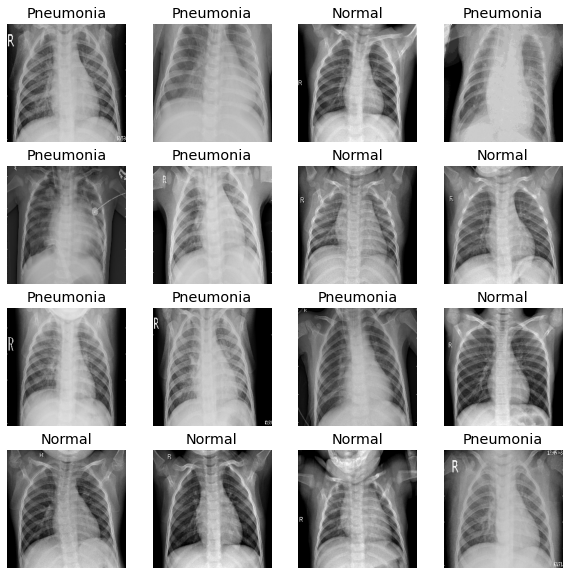

In [21]:
# Viewing of some randomly selected images in the train folder
plt.figure(figsize=(10,10))
j = -1
for i in random.sample(range(0, len(x_2train) - 1), 16):
    j += 1
    ax=plt.subplot(4, 4, j+1)
    plt.imshow(np.squeeze(x_2train[i]), cmap=plt.get_cmap("gray"))

    if y_2train[i] == "normal" :
        plt.title("Normal")
    
    elif y_2train[i] == "pneumonia" :
        plt.title("Pneumonia")

    plt.axis("off")

plt.show() 

In [22]:
# Converting class vector for train data
classes_2train = preprocessing.LabelEncoder()
classes_2train.fit(y_2train)
classes_2train = classes_2train.transform(y_2train)
onehot_y_2train = keras.utils.to_categorical(classes_2train, 2)

In [23]:
# Converting class vector for validation data
classes_2val = preprocessing.LabelEncoder()
classes_2val.fit(y_2val)
classes_2val = classes_2val.transform(y_2val)
onehot_y_2val = keras.utils.to_categorical(classes_2val, 2)

In [24]:
#Converting class vector for test data
classes_2test = preprocessing.LabelEncoder()
classes_2test.fit(y_2test)
classes_2test = classes_2test.transform(y_2test)
onehot_y_2test = keras.utils.to_categorical(classes_2test, 2)

## Building CNN model

In [25]:
# Define input shape
input_shape = (224, 224, 3)
num_classes = 2

In [26]:
# Define architecture of model
input_model = layers.Input(shape=input_shape)
data_augmentation= layers.RandomFlip("horizontal")(input_model)
conv_1 = layers.Conv2D(32, kernel_size=(3,3), activation="relu")(data_augmentation)
max_pool_1 = layers.MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = layers.Conv2D(64, kernel_size=(3,3), activation="relu")(max_pool_1)
max_pool_2 = layers.MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = layers.Conv2D(128, kernel_size=(3,3), activation="relu")(max_pool_2)
max_pool_3 = layers.MaxPooling2D(pool_size=(2,2))(conv_3)
flatten_1 = layers.Flatten()(max_pool_3)
drop_out_1 = layers.Dropout(0.2)(flatten_1)
output = layers.Dense(num_classes, activation="softmax")(drop_out_1)
                                 
model_1 = keras.Model(inputs=input_model, outputs=output)

In [27]:
# Summarize model
print(model_1.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856 

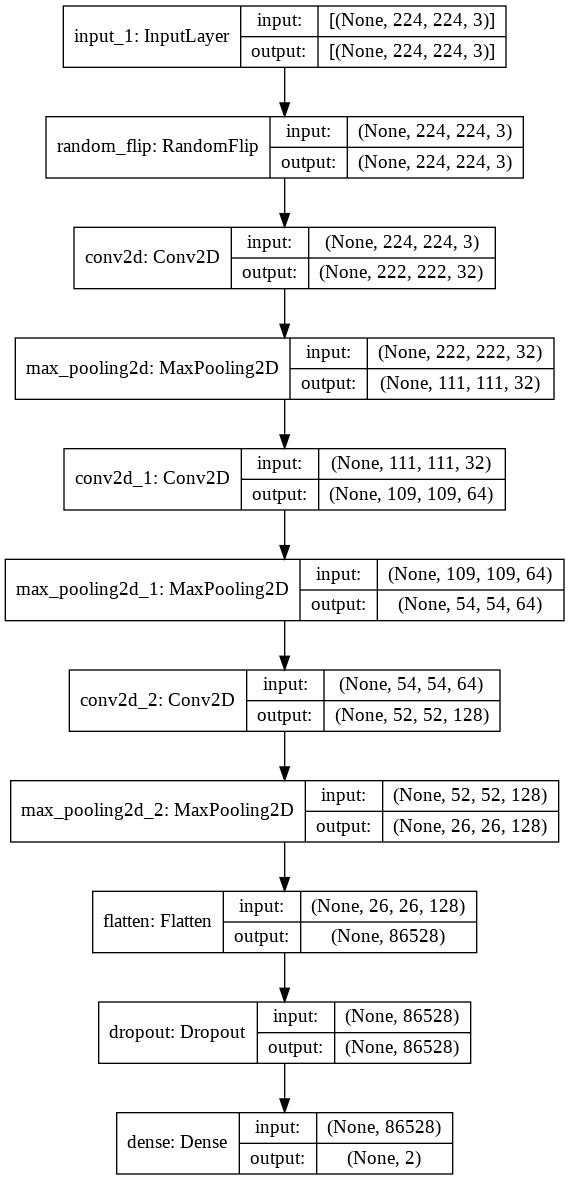

In [28]:
keras.utils.plot_model(model_1, "CNN1_2classes.png", show_shapes=True)

## Trainning CNN model

In [29]:
batch_size = 32
epochs = 30
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-5)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0)

model_1.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [30]:
history_1 = model_1.fit(x_2train, onehot_y_2train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(x_2val, onehot_y_2val),
                    shuffle=True,
                    callbacks=[callback])

Epoch 1/30
131/131 [==============================] - 21s 38ms/step - loss: 0.3869 - accuracy: 0.8251 - val_loss: 0.1930 - val_accuracy: 0.9150
Epoch 2/30
131/131 [==============================] - 4s 31ms/step - loss: 0.1521 - accuracy: 0.9410 - val_loss: 0.1168 - val_accuracy: 0.9494
Epoch 3/30
131/131 [==============================] - 4s 31ms/step - loss: 0.1161 - accuracy: 0.9553 - val_loss: 0.0869 - val_accuracy: 0.9723
Epoch 4/30
131/131 [==============================] - 4s 31ms/step - loss: 0.0991 - accuracy: 0.9634 - val_loss: 0.0778 - val_accuracy: 0.9752
Epoch 5/30
131/131 [==============================] - 4s 31ms/step - loss: 0.0859 - accuracy: 0.9689 - val_loss: 0.0722 - val_accuracy: 0.9780
Epoch 6/30
131/131 [==============================] - 4s 31ms/step - loss: 0.0874 - accuracy: 0.9661 - val_loss: 0.1029 - val_accuracy: 0.9561
Epoch 7/30
131/131 [==============================] - 4s 31ms/step - loss: 0.0900 - accuracy: 0.9651 - val_loss: 0.0903 - val_accuracy: 0.963

## Evaluating CNN model

In [31]:
# Evaluate model with test data
_, acc = model_1.evaluate(x_2test, onehot_y_2test, verbose=1)
print("Accuracy = " '%.3f' % (acc * 100.0))

20/20 [==============================] - 0s 17ms/step - loss: 0.5702 - accuracy: 0.8189
Accuracy = 81.891


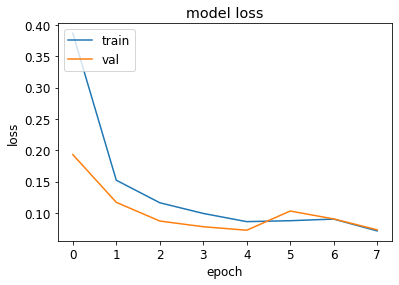

In [32]:
# Plot history for loss
plt.plot(history_1.history["loss"])
plt.plot(history_1.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

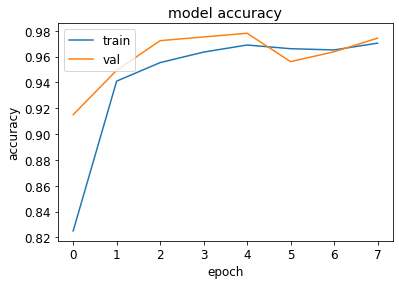

In [33]:
# Plot history for accuracy
plt.plot(history_1.history["accuracy"])
plt.plot(history_1.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [34]:
y_2pred = model_1.predict(x_2test)
y_2pred = np.argmax(y_2pred, axis=1)

y_2true = np.argmax(onehot_y_2test, axis=1)

In [35]:
print(classification_report(y_2true, y_2pred, target_names = ['normal', 'pneumonia']))

              precision    recall  f1-score   support

      normal       0.98      0.53      0.69       234
   pneumonia       0.78      0.99      0.87       390

    accuracy                           0.82       624
   macro avg       0.88      0.76      0.78       624
weighted avg       0.85      0.82      0.80       624



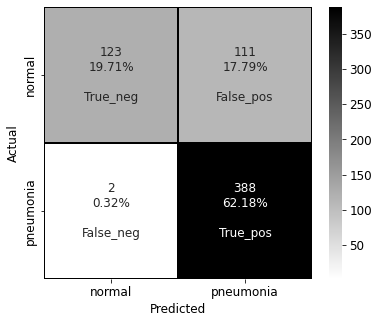

In [36]:
cm = confusion_matrix(y_2true, y_2pred)
names = ['normal', 'pneumonia']

cm = pd.DataFrame(cm, index = names , columns = names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

group_counts = ["{0:0.0f}".format(value) for value in cm.to_numpy().flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.to_numpy().flatten()/np.sum(cm.to_numpy())]
group_class = ["True_neg", "False_pos", "False_neg", "True_pos"]
labels = [f"{v1}\n{v2}\n\n{v3}" for v1, v2, v3 in zip(group_counts,group_percentages,group_class)]
labels = np.asarray(labels).reshape(2,2)

plt.figure(figsize = (6,5))
sns.heatmap(cm,
            annot=labels,
            cmap= "binary",
            linecolor = 'black',
            linewidth = 1,
            fmt='')

# **Part 2 : CNN with 3 classes --> Normal, Bacterial pneumonia or Viral pneumonia**

In [16]:
# Converting images in pixel matrix in aray
x_3train = [img_to_array(image) for image in img_data_train_normal]
x_3train.extend([img_to_array(image) for image in img_data_train_bacterial_pneumonia])
x_3train.extend([img_to_array(image) for image in img_data_train_viral_pneumonia])
x_3train = np.asarray(x_3train)

x_3val = [img_to_array(image) for image in img_data_val_normal]
x_3val.extend([img_to_array(image) for image in img_data_val_bacterial_pneumonia])
x_3val.extend([img_to_array(image) for image in img_data_val_viral_pneumonia])
x_3val = np.asarray(x_3val)

x_3test = [img_to_array(image) for image in img_data_test_normal]
x_3test.extend([img_to_array(image) for image in img_data_test_bacterial_pneumonia])
x_3test.extend([img_to_array(image) for image in img_data_test_viral_pneumonia])
x_3test = np.asarray(x_3test)

In [17]:
# Creating label matrix "normal" or "bacterial_pneumonia" or "viral_pneumonia"
y_3train = ["normal" for image in img_data_train_normal]
y_3train.extend(["bacterial_pneumonia" for image in img_data_train_bacterial_pneumonia])
y_3train.extend(["viral_pneumonia" for image in img_data_train_viral_pneumonia])
y_3train = np.asarray(y_3train)

y_3val = ["normal" for image in img_data_val_normal]
y_3val.extend(["bacterial_pneumonia" for image in img_data_val_bacterial_pneumonia])
y_3val.extend(["viral_pneumonia" for image in img_data_val_viral_pneumonia])
y_3val = np.asarray(y_3val)

y_3test = ["normal" for image in img_data_test_normal]
y_3test.extend(["bacterial_pneumonia" for image in img_data_test_bacterial_pneumonia])
y_3test.extend(["viral_pneumonia" for image in img_data_test_viral_pneumonia])
y_3test = np.asarray(y_3test)

In [18]:
print(f"Type of x_3train : {type(x_3train)}")
print(f"Type of y_3train : {type(y_3train)}")

Type of x_3train : <class 'numpy.ndarray'>
Type of y_3train : <class 'numpy.ndarray'>


In [19]:
print(f"Shape of x_3train : {x_3train.shape}")
print(f"Shape of y_3train : {y_3train.shape}")

print(f"Shape of x_3validation : {x_3val.shape}")
print(f"Shape of y_3validation : {y_3val.shape}")

Shape of x_3train : (4185, 224, 224, 3)
Shape of y_3train : (4185,)
Shape of x_3validation : (1047, 224, 224, 3)
Shape of y_3validation : (1047,)


In [20]:
# Scaling images to the [0, 1] range in 32 bits
x_3train = x_3train.astype("float32") / 255
x_3val = x_3val.astype("float32") / 255
x_3test = x_3test.astype("float32") / 255

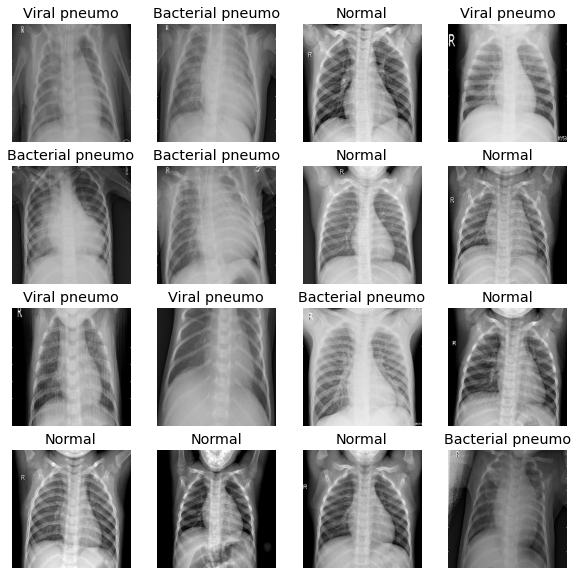

In [21]:
# Viewing of some randomly selected images in the train folder
plt.figure(figsize=(10,10))
j = -1
for i in random.sample(range(0, len(x_3train) - 1), 16):
    j += 1
    ax=plt.subplot(4, 4, j+1)
    plt.imshow(np.squeeze(x_3train[i]), cmap=plt.get_cmap("gray"))

    if y_3train[i] == "normal" :
        plt.title("Normal")

    elif y_3train[i] == "bacterial_pneumonia" :
        plt.title("Bacterial pneumo")

    elif y_3train[i] == "viral_pneumonia" :
        plt.title("Viral pneumo")

    plt.axis("off")

plt.show()

In [22]:
# Converting class vector for train data
classes_3train = preprocessing.LabelEncoder()
classes_3train.fit(y_3train)
classes_3train = classes_3train.transform(y_3train)
onehot_y_3train = keras.utils.to_categorical(classes_3train, 3)

In [23]:
# Converting class vector for validation data
classes_3val = preprocessing.LabelEncoder()
classes_3val.fit(y_3val)
classes_3val = classes_3val.transform(y_3val)
onehot_y_3val = keras.utils.to_categorical(classes_3val, 3)

In [24]:
# Converting class vector for test data
classes_3test = preprocessing.LabelEncoder()
classes_3test.fit(y_3test)
classes_3test = classes_3test.transform(y_3test)
onehot_y_3test = keras.utils.to_categorical(classes_3test, 3)

## Building CNN model

In [25]:
# Define input shape
input_shape = (224, 224, 3)
num_classes = 3

In [26]:
# Define architecture of model
input_model = layers.Input(shape=input_shape)
data_augmentation = layers.RandomFlip("horizontal")(input_model)
conv_1 = layers.Conv2D(32, kernel_size=(3,3), activation="relu")(data_augmentation)
max_pool_1 = layers.MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = layers.Conv2D(64, kernel_size=(3,3), activation="relu")(max_pool_1)
max_pool_2 = layers.MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = layers.Conv2D(128, kernel_size=(3,3), activation="relu")(max_pool_2)
max_pool_3 = layers.MaxPooling2D(pool_size=(2,2))(conv_3)
flatten_1 = layers.Flatten()(max_pool_3)
drop_out_1 = layers.Dropout(0.2)(flatten_1)
output = layers.Dense(num_classes, activation="softmax")(drop_out_1)
                                 
model_2 = keras.Model(inputs=input_model, outputs=output)

In [27]:
print(model_2.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856 

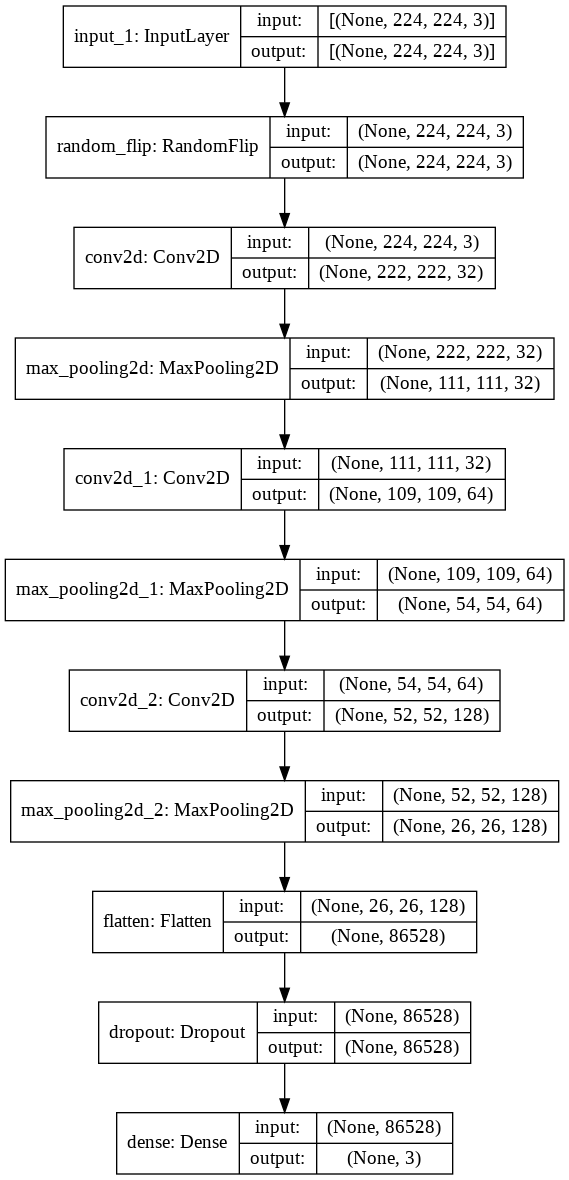

In [28]:
keras.utils.plot_model(model_2, "CNN2_3classes.png", show_shapes=True)

## Trainning CNN model

In [29]:
batch_size = 64
epochs = 30
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-5)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0)

model_2.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [30]:
history_2 = model_2.fit(x_3train, onehot_y_3train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(x_3val, onehot_y_3val),
                    shuffle=True,
                    callbacks=[callback])

Epoch 1/30
66/66 [==============================] - 7s 74ms/step - loss: 0.9638 - accuracy: 0.5460 - val_loss: 0.7398 - val_accuracy: 0.6905
Epoch 2/30
66/66 [==============================] - 4s 58ms/step - loss: 0.6474 - accuracy: 0.7300 - val_loss: 0.5706 - val_accuracy: 0.7679
Epoch 3/30
66/66 [==============================] - 4s 58ms/step - loss: 0.5451 - accuracy: 0.7730 - val_loss: 0.5320 - val_accuracy: 0.7775
Epoch 4/30
66/66 [==============================] - 4s 59ms/step - loss: 0.5109 - accuracy: 0.7759 - val_loss: 0.4813 - val_accuracy: 0.7851
Epoch 5/30
66/66 [==============================] - 4s 58ms/step - loss: 0.4910 - accuracy: 0.7828 - val_loss: 0.4680 - val_accuracy: 0.7937
Epoch 6/30
66/66 [==============================] - 4s 58ms/step - loss: 0.4804 - accuracy: 0.7892 - val_loss: 0.4916 - val_accuracy: 0.7775
Epoch 7/30
66/66 [==============================] - 4s 58ms/step - loss: 0.4818 - accuracy: 0.7849 - val_loss: 0.4693 - val_accuracy: 0.7851
Epoch 8/30
66

## Evaluating CNN model

In [31]:
# Evaluate model with test data
_, acc = model_2.evaluate(x_3test, onehot_y_3test, verbose=1)
print("Accuracy = " '%.3f' % (acc * 100.0))

20/20 [==============================] - 1s 16ms/step - loss: 0.6783 - accuracy: 0.7115
Accuracy = 71.154


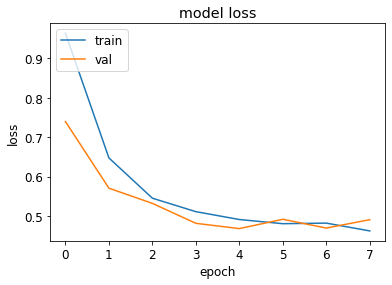

In [32]:
# Plot history for loss
plt.plot(history_2.history["loss"])
plt.plot(history_2.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

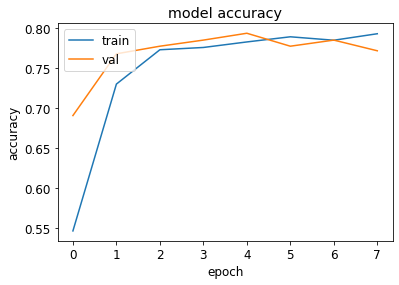

In [33]:
# Plot history for accuracy
plt.plot(history_2.history["accuracy"])
plt.plot(history_2.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [34]:
y_3pred = model_2.predict(x_3test)
y_3pred = np.argmax(y_3pred, axis=1)

y_3true = np.argmax(onehot_y_3test, axis=1)

In [35]:
print(classification_report(y_3true, y_3pred, target_names = ['normal', 'bacterial_pneumonia', 'viral_pneumonia']))

                     precision    recall  f1-score   support

             normal       0.59      0.98      0.74       242
bacterial_pneumonia       0.97      0.72      0.82       234
    viral_pneumonia       0.78      0.26      0.39       148

           accuracy                           0.71       624
          macro avg       0.78      0.65      0.65       624
       weighted avg       0.78      0.71      0.69       624



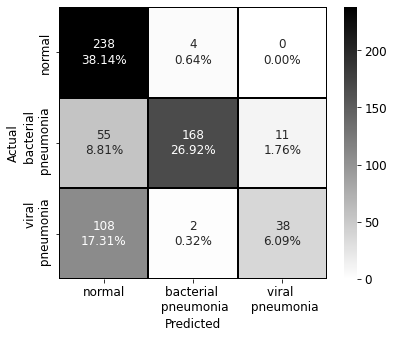

In [36]:
cm = confusion_matrix(y_3true, y_3pred)
names = ['normal', 'bacterial \n pneumonia', 'viral \n pneumonia']

cm = pd.DataFrame(cm, index = names , columns = names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

group_counts = ["{0:0.0f}".format(value) for value in cm.to_numpy().flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.to_numpy().flatten()/np.sum(cm.to_numpy())]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

plt.figure(figsize = (6,5))
sns.heatmap(cm,
            annot=labels,
            cmap= "binary",
            linecolor = 'black',
            linewidth = 1,
            fmt='')

# **Part 3 : Try to improve 3 classes CNN model using transfer learning with Inception V3**

## Building CNN model

In [37]:
input_shape = (224, 224, 3)
num_classes = 3
input=layers.Input(shape = (224, 224, 3))
data_augmentation = layers.RandomFlip("horizontal")(input)

base_model = InceptionV3(include_top=False, input_shape = input_shape, weights = "imagenet")

for layer in base_model.layers:
  layer.trainable=False

pre_trained = base_model(data_augmentation)
flatten = layers.Flatten() (pre_trained)
dense_1 = layers.Dense(256, activation="relu")(flatten)
drop_out_1 = layers.Dropout(0.2)(dense_1)
dense_2 = layers.Dense(128, activation="relu")(drop_out_1)
flatten = layers.Flatten() (pre_trained)
drop_out_2 = layers.Dropout(0.2)(dense_2)
output = layers.Dense(num_classes, activation="softmax")(drop_out_2)

model_3 = keras.Model(inputs=input, outputs=output)

In [38]:
print(model_3.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
random_flip_1 (RandomFlip)   (None, 224, 224, 3)       0         
_________________________________________________________________
inception_v3 (Functional)    (None, 5, 5, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 51200)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               13107456  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               3289

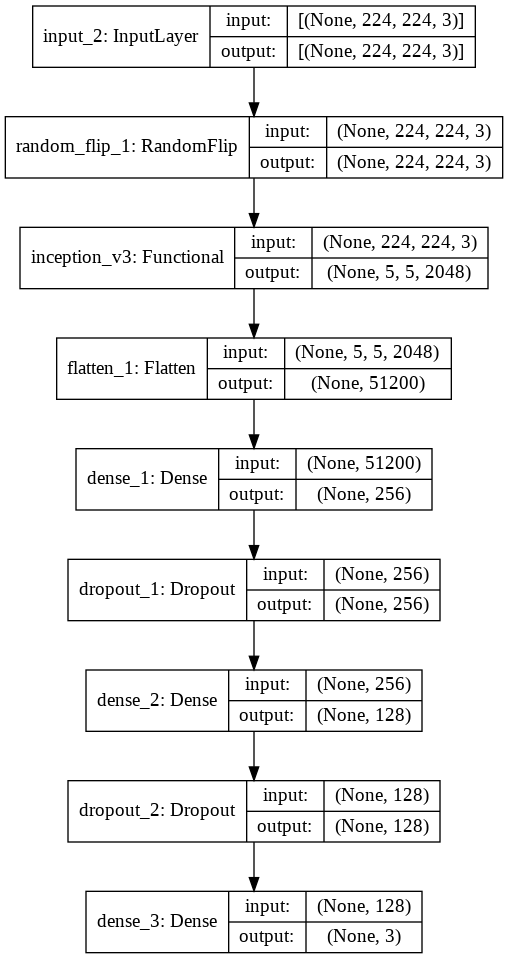

In [39]:
keras.utils.plot_model(model_3, "transfer_learning_InceptionV3_3classes.png", show_shapes=True)

## Training CNN model

In [40]:
batch_size = 64
epochs = 30
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-5)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0)
model_3.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [41]:
history_3 = model_3.fit(x_3train, onehot_y_3train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(x_3val, onehot_y_3val),
                    shuffle=True,
                    callbacks=[callback])

Epoch 1/30
66/66 [==============================] - 13s 136ms/step - loss: 0.9728 - accuracy: 0.6332 - val_loss: 0.6531 - val_accuracy: 0.7096
Epoch 2/30
66/66 [==============================] - 7s 103ms/step - loss: 0.5900 - accuracy: 0.7393 - val_loss: 0.5075 - val_accuracy: 0.7746
Epoch 3/30
66/66 [==============================] - 7s 103ms/step - loss: 0.5382 - accuracy: 0.7575 - val_loss: 0.4848 - val_accuracy: 0.7851
Epoch 4/30
66/66 [==============================] - 7s 103ms/step - loss: 0.5252 - accuracy: 0.7780 - val_loss: 0.4661 - val_accuracy: 0.7975
Epoch 5/30
66/66 [==============================] - 7s 104ms/step - loss: 0.4874 - accuracy: 0.7914 - val_loss: 0.4749 - val_accuracy: 0.7956
Epoch 6/30
66/66 [==============================] - 7s 103ms/step - loss: 0.4719 - accuracy: 0.7900 - val_loss: 0.4670 - val_accuracy: 0.8004
Epoch 7/30
66/66 [==============================] - 7s 103ms/step - loss: 0.4509 - accuracy: 0.8012 - val_loss: 0.4642 - val_accuracy: 0.8004
Epoch

## Evaluating CNN model

In [42]:
#Evaluate model with test data
_, acc = model_3.evaluate(x_3test, onehot_y_3test, verbose=1)
print("Accuracy = " '%.3f' % (acc * 100.0))

20/20 [==============================] - 2s 61ms/step - loss: 0.7145 - accuracy: 0.7532
Accuracy = 75.321


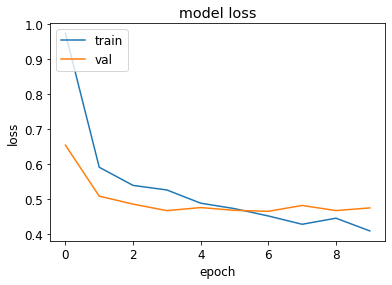

In [43]:
#Plot history for loss
plt.plot(history_3.history["loss"])
plt.plot(history_3.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

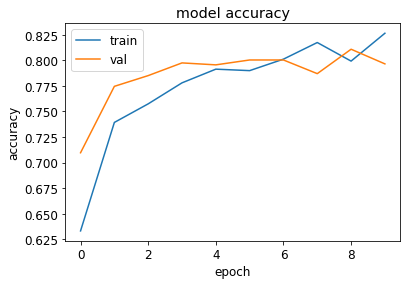

In [44]:
#Plot history for accuracy
plt.plot(history_3.history["accuracy"])
plt.plot(history_3.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [45]:
y_3pred = model_3.predict(x_3test)
y_3pred = np.argmax(y_3pred, axis=1)

y_3true = np.argmax(onehot_y_3test, axis=1)

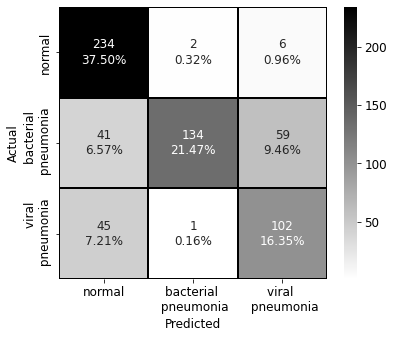

In [46]:
cm = confusion_matrix(y_3true, y_3pred)
names = ['normal', 'bacterial \n pneumonia', 'viral \n pneumonia']

cm = pd.DataFrame(cm, index = names , columns = names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

group_counts = ["{0:0.0f}".format(value) for value in cm.to_numpy().flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.to_numpy().flatten()/np.sum(cm.to_numpy())]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

plt.figure(figsize = (6,5))
sns.heatmap(cm,
            annot=labels,
            cmap= "binary",
            linecolor = 'black',
            linewidth = 1,
            fmt='')

# **Part 4 : Try to improve the 3 classes CNN model using transfer learning**

## Building CNN model

In [47]:
# Cut the last layers of model_2 before flatten
cut_model_2 = Model(inputs=model_2.input, outputs=model_2.layers[-4].output)

In [48]:
model_2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       73856 

In [49]:
cut_model_2.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 224, 224, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 222, 222, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 111, 111, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 109, 109, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 54, 54, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 52, 52, 128)       7385

In [50]:
# Freeze the parameters
for layer in cut_model_2.layers:
  layer.trainable=False

In [51]:
# Define input shape
input_shape = (224, 224, 3)
num_classes = 3

In [52]:
# Define architecture of model
input_model = layers.Input(shape=input_shape)
base_model = cut_model_2(input_model)
conv_1 = layers.Conv2D(32, kernel_size=(3,3), activation="relu")(base_model)
max_pool_1 = layers.MaxPooling2D(pool_size=(2,2))(conv_1)
conv_2 = layers.Conv2D(64, kernel_size=(3,3), activation="relu")(max_pool_1)
max_pool_2 = layers.MaxPooling2D(pool_size=(2,2))(conv_2)
conv_3 = layers.Conv2D(128, kernel_size=(3,3), activation="relu")(max_pool_2)
max_pool_3 = layers.MaxPooling2D(pool_size=(2,2))(conv_3)
flatten_1 = layers.Flatten()(max_pool_3)
drop_out_1 = layers.Dropout(0.2)(flatten_1)
output = layers.Dense(num_classes, activation="softmax")(drop_out_1)                             

model_4 = keras.Model(inputs=input_model, outputs=output)

In [53]:
print(model_4.summary())

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
model_2 (Functional)         (None, 26, 26, 128)       93248     
_________________________________________________________________
conv2d_97 (Conv2D)           (None, 24, 24, 32)        36896     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
conv2d_98 (Conv2D)           (None, 10, 10, 64)        18496     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_99 (Conv2D)           (None, 3, 3, 128)         7385

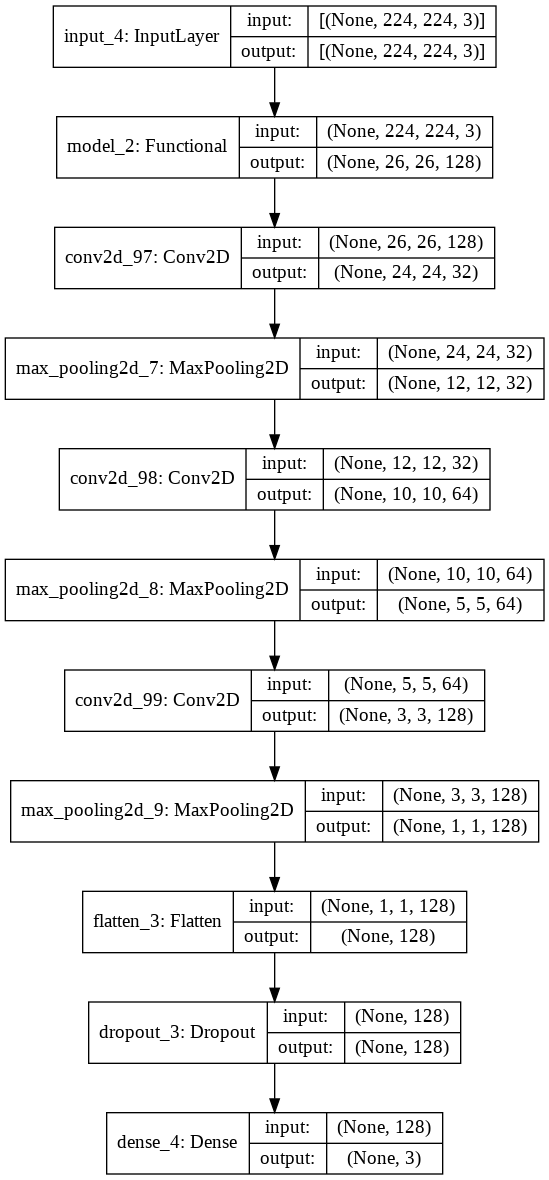

In [54]:
keras.utils.plot_model(model_4, "transfer_learning_CNN2_3classes.png", show_shapes=True)

## Training CNN model

In [55]:
batch_size = 32
epochs = 100
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay=1e-5)
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0)

model_4.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

In [56]:
history_4 = model_4.fit(x_3train, onehot_y_3train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(x_3val, onehot_y_3val),
                    shuffle=True,
                    callbacks=[callback])

Epoch 1/100
131/131 [==============================] - 4s 22ms/step - loss: 0.9156 - accuracy: 0.5924 - val_loss: 0.8256 - val_accuracy: 0.5998
Epoch 2/100
131/131 [==============================] - 2s 17ms/step - loss: 0.7249 - accuracy: 0.6683 - val_loss: 0.6911 - val_accuracy: 0.7077
Epoch 3/100
131/131 [==============================] - 2s 17ms/step - loss: 0.6829 - accuracy: 0.7013 - val_loss: 0.6654 - val_accuracy: 0.7135
Epoch 4/100
131/131 [==============================] - 2s 18ms/step - loss: 0.6643 - accuracy: 0.7130 - val_loss: 0.6530 - val_accuracy: 0.7221
Epoch 5/100
131/131 [==============================] - 2s 17ms/step - loss: 0.6436 - accuracy: 0.7202 - val_loss: 0.6321 - val_accuracy: 0.7278
Epoch 6/100
131/131 [==============================] - 2s 18ms/step - loss: 0.6222 - accuracy: 0.7372 - val_loss: 0.6078 - val_accuracy: 0.7402
Epoch 7/100
131/131 [==============================] - 2s 17ms/step - loss: 0.6053 - accuracy: 0.7446 - val_loss: 0.6030 - val_accuracy:

## Evaluating CNN model

In [57]:
# Evaluate model with test data
_, acc = model_4.evaluate(x_3test, onehot_y_3test, verbose=1)
print("Accuracy = " '%.3f' % (acc * 100.0))

20/20 [==============================] - 0s 13ms/step - loss: 0.4664 - accuracy: 0.8365
Accuracy = 83.654


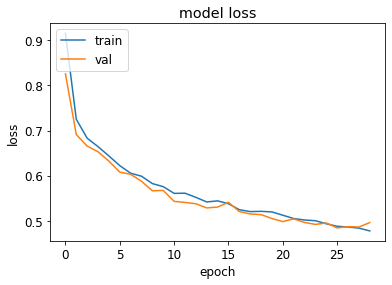

In [58]:
# Plot history for loss
plt.plot(history_4.history["loss"])
plt.plot(history_4.history["val_loss"])
plt.title("model loss")
plt.ylabel("loss")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

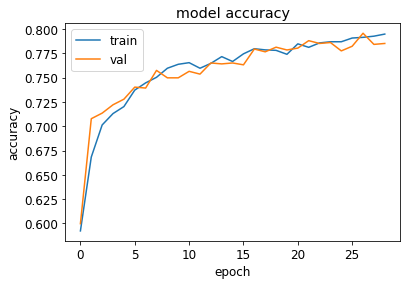

In [59]:
# Plot history for accuracy
plt.plot(history_4.history["accuracy"])
plt.plot(history_4.history["val_accuracy"])
plt.title("model accuracy")
plt.ylabel("accuracy")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

In [60]:
y_3pred = model_4.predict(x_3test)
y_3pred = np.argmax(y_3pred, axis=1)

y_3true = np.argmax(onehot_y_3test, axis=1)

In [61]:
print(classification_report(y_3true, y_3pred, target_names = ['normal', 'bacterial_pneumonia', 'viral_pneumonia']))

                     precision    recall  f1-score   support

             normal       0.80      0.95      0.86       242
bacterial_pneumonia       0.95      0.82      0.88       234
    viral_pneumonia       0.75      0.68      0.72       148

           accuracy                           0.84       624
          macro avg       0.83      0.82      0.82       624
       weighted avg       0.84      0.84      0.84       624



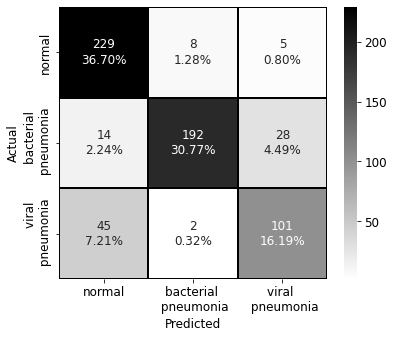

In [62]:
cm = confusion_matrix(y_3true, y_3pred)
names = ['normal', 'bacterial \n pneumonia', 'viral \n pneumonia']

cm = pd.DataFrame(cm, index = names , columns = names)
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'

group_counts = ["{0:0.0f}".format(value) for value in cm.to_numpy().flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cm.to_numpy().flatten()/np.sum(cm.to_numpy())]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts,group_percentages)]
labels = np.asarray(labels).reshape(3,3)

plt.figure(figsize = (6,5))
sns.heatmap(cm,
            annot=labels,
            cmap= "binary",
            linecolor = 'black',
            linewidth = 1,
            fmt='')